In [1]:
import tensorflow as tf
import os
import pandas as pd
import cv2
from skimage.transform import rescale, resize
from tensorflow import keras
import numpy as np
from sklearn.utils import class_weight
import tensorflow_addons as tfa
import pickle
from skimage.io import imread
from sklearn.utils import shuffle
from matplotlib import pyplot as plt
from albumentations import Resize


C:\Users\Lenovo\anaconda3\envs\my_env3.10\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
C:\Users\Lenovo\anaconda3\envs\my_env3.10\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an 

In [2]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("Built with CUDA:", tf.test.is_built_with_cuda())
print("GPU Available:", tf.config.list_physical_devices('GPU'))




TensorFlow version: 2.10.1
Built with CUDA: True
GPU Available: []


In [3]:
import tensorflow as tf
import pandas as pd
import cv2
import numpy as np
import tensorflow_addons as tfa
import skimage
import matplotlib
import sklearn

# Print the versions
print("TensorFlow Version:", tf.__version__)
print("Pandas Version:", pd.__version__)
print("OpenCV Version:", cv2.__version__)
print("NumPy Version:", np.__version__)
print("TensorFlow Addons Version:", tfa.__version__)
print("Scikit-Image Version:", skimage.__version__)
print("Matplotlib Version:", matplotlib.__version__)
print("Scikit-Learn Version:", sklearn.__version__)


TensorFlow Version: 2.10.1
Pandas Version: 2.2.3
OpenCV Version: 4.10.0
NumPy Version: 1.24.4
TensorFlow Addons Version: 0.22.0
Scikit-Image Version: 0.24.0
Matplotlib Version: 3.9.2
Scikit-Learn Version: 1.5.2


In [4]:
import albumentations
print(albumentations.__version__)

1.4.23


In [5]:
def filenames(part, train=True):
    # Correct root path
    root = 'D:\Project Mura\MURA-v1.1/'  
    
    # Update the CSV paths based on your description
    if train:
        csv_path = "D:\Project Mura\MURA-v1.1/train_image_paths.csv"
    else:
        csv_path = "D:\Project Mura\MURA-v1.1/valid_image_paths.csv"
    
    # Read the CSV file and process the image paths
    with open(csv_path, 'rb') as F:
        d = F.readlines()
        if part == 'all':
            imgs = [root + str(x, encoding='utf-8').strip() for x in d]
        else:
            imgs = [root + str(x, encoding='utf-8').strip().replace('MURA-v1.1/', '') for x in d if
                            str(x, encoding='utf-8').strip().split('/')[2] == part]

    # Extract the labels based on the image path
    labels = [x.split('_')[-1].split('/')[0] for x in imgs]
    return imgs, labels



#To icrop a image from center
def crop_center(img,cropx,cropy):
    y,x,_ = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]


In [6]:
from albumentations import (
    Compose, HorizontalFlip, CLAHE, HueSaturationValue,
    RandomBrightnessContrast, RandomGamma,
    ToFloat, ShiftScaleRotate, Resize
)

AUGMENTATIONS_TRAIN = Compose([
    HorizontalFlip(p=0.5),
    RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),  # Adjusts both brightness and contrast
    RandomGamma(gamma_limit=(80, 120), p=0.5),
    RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),  # Adjusts both brightness and contrast
    ShiftScaleRotate(
        shift_limit=0.0625, scale_limit=0.1, 
        rotate_limit=15, border_mode=cv2.BORDER_REFLECT_101, p=0.8), 
    ToFloat(max_value=255)
])

AUGMENTATIONS_TEST = Compose([
    # CLAHE(p=1.0, clip_limit=2.0),
    ToFloat(max_value=255)
])


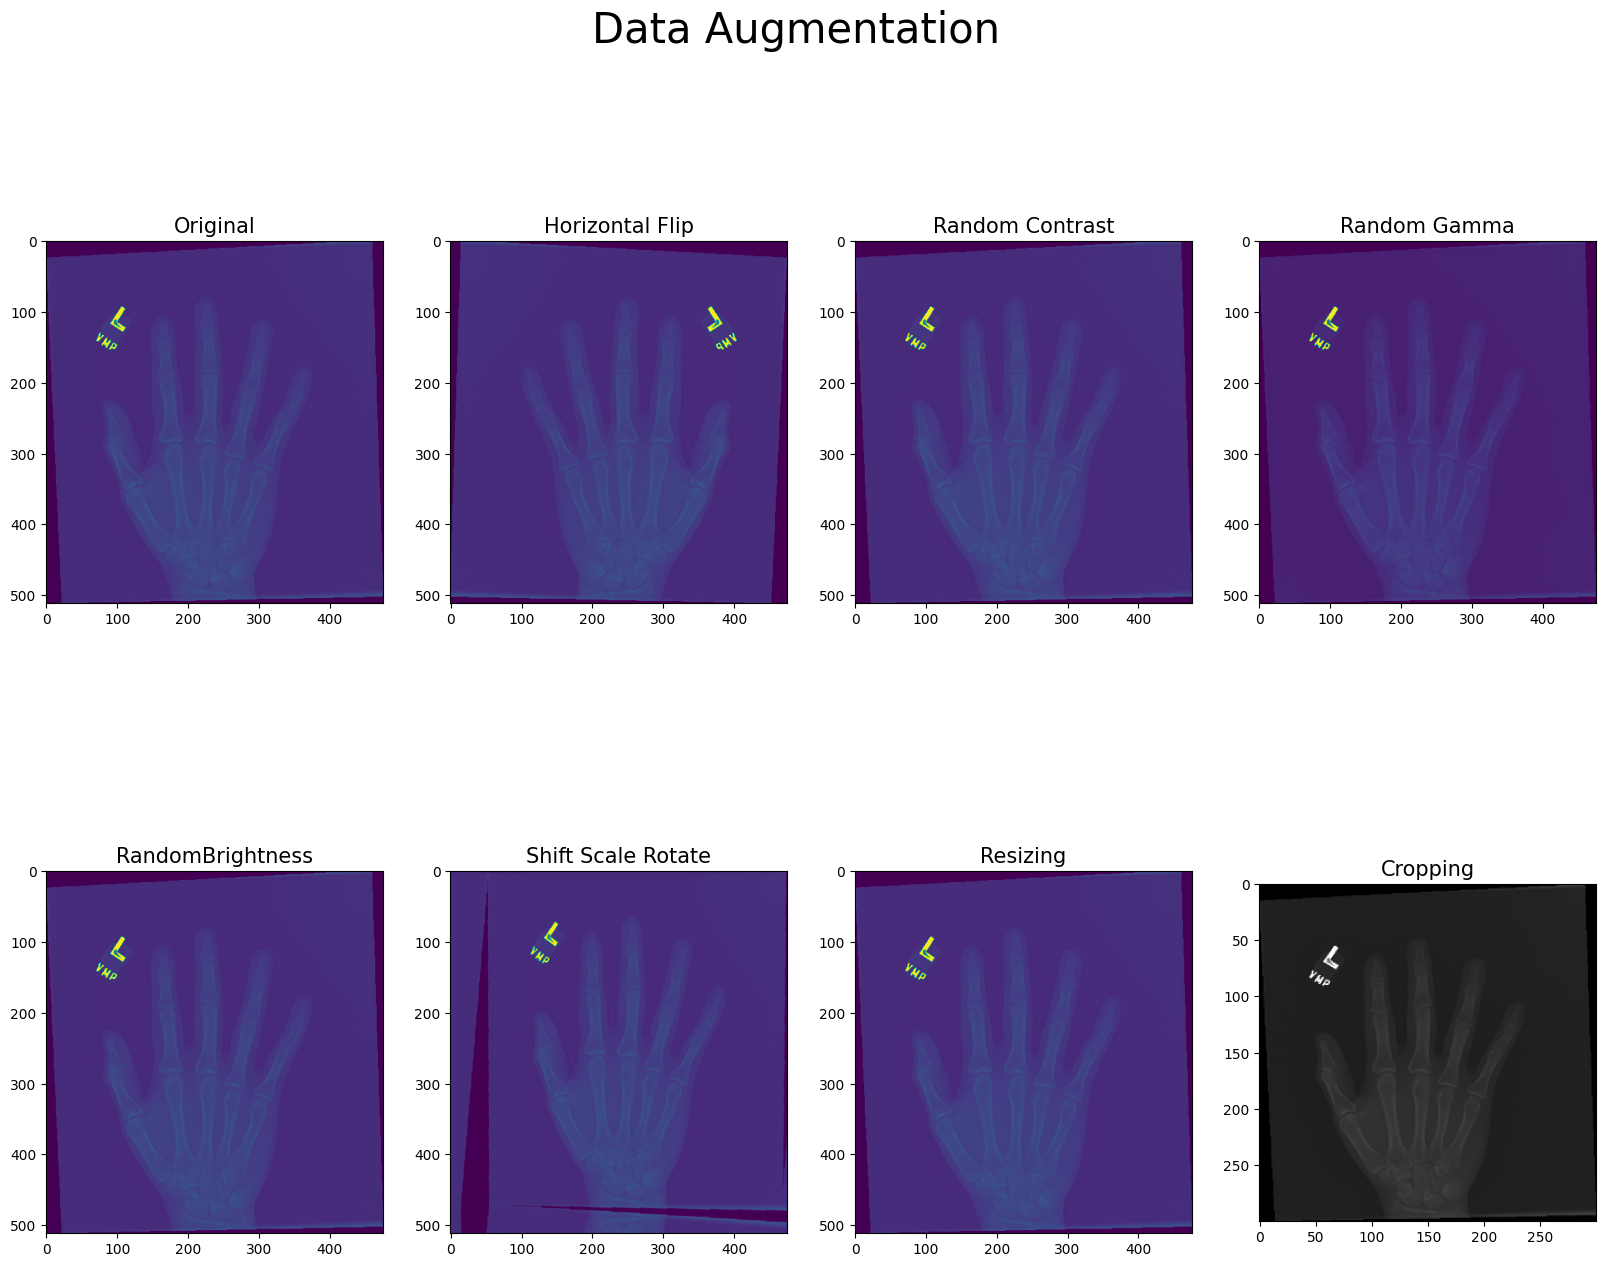

In [7]:

albumentation_list =  [
    HorizontalFlip(p=0.5),
    RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),  # Adjusts both brightness and contrast
    RandomGamma(gamma_limit=(80, 120), p=0.5),
    RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),  # Adjusts both brightness and contrast
    ShiftScaleRotate(
        shift_limit=0.0625, scale_limit=0.1, 
        rotate_limit=15, border_mode=cv2.BORDER_REFLECT_101, p=0.8), 
    ToFloat(max_value=255)
]

root='D:\Project Mura\MURA-v1.1/'
chosen_image = imread(root+'train/XR_HAND/patient00153/study1_positive/image1.png')

img_matrix_list = []
bboxes_list = []

for aug_type in albumentation_list:
    img = aug_type(image=chosen_image)['image']
    img_matrix_list.append(img)

img = resize(chosen_image, (300, 300, 3))
img_matrix_list.append(img)
img_matrix_list.append(crop_center(img, 224, 224))

img_matrix_list.insert(0, chosen_image)

titles_list = ["Original", "Horizontal Flip", "Random Contrast", "Random Gamma", "RandomBrightness",
               "Shift Scale Rotate", "Resizing", "Cropping"]

def plot_multiple_img(img_matrix_list, title_list, ncols, main_title="Data Augmentation"):
    fig, myaxes = plt.subplots(figsize=(20, 15), nrows=2, ncols=ncols, squeeze=True)
    fig.suptitle(main_title, fontsize=30)
    for i, (img, title) in enumerate(zip(img_matrix_list, title_list)):
        myaxes[i // ncols][i % ncols].imshow(img)
        myaxes[i // ncols][i % ncols].set_title(title, fontsize=15)
    plt.show()

plot_multiple_img(img_matrix_list, titles_list, ncols=4)


In [8]:
class My_Custom_Generator(keras.utils.Sequence) :
  
  def __init__(self, image_filenames, labels, batch_size,transform) :
    self.image_filenames = image_filenames
    self.labels = labels
    self.batch_size = batch_size
    self.t= transform
    
  def __len__(self) :
    return int(np.ceil(len(self.image_filenames) / float(self.batch_size)))

  
  def __getitem__(self, idx) :
    batch_x = self.image_filenames[idx * self.batch_size : (idx+1) * self.batch_size]
    batch_y = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]
    x=[]
    for file in batch_x:
        img= imread(file)
        img= self.t(image=img)["image"]
        img= resize(img,(300,300,3))
        img= crop_center(img,224,224)
        x.append(img)
    x=np.array(x)/255.0
    y= np.array(batch_y)
    return x,y

In [9]:
part='XR_HAND'
imgs,labels= filenames(part=part)
vimgs,vlabels= filenames(part=part,train=False)
print(labels.count('positive'),labels.count('negative'))
training_data= labels.count('positive')+labels.count('negative')
print("Training Data: ", training_data)
y_data= [0 if x=='positive' else 1 for x in labels]
y_data= keras.utils.to_categorical(y_data)
print(vlabels.count('positive'),vlabels.count('negative'))
validation_data= vlabels.count('positive')+vlabels.count('negative')
print("Validation Data: ", validation_data)
vy_data= [0 if x=='positive' else 1 for x in vlabels]
vy_data= keras.utils.to_categorical(vy_data)

1484 4059
Training Data:  5543
189 271
Validation Data:  460


In [10]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Example data (you should replace this with your actual data)
# y_data = ...

y_integers = np.argmax(y_data, axis=1)  # If y_data is one-hot encoded
class_weights = compute_class_weight('balanced', classes=np.unique(y_integers), y=y_integers)

# Convert the class weights into a dictionary for easy access
d_class_weights = dict(enumerate(class_weights))

print(d_class_weights)


{0: 1.8675876010781671, 1: 0.6828036462182804}


In [11]:
batch_size = 2
imgs, y_data = shuffle(imgs, y_data)
#vimgs, vy_data = shuffle(vimgs, vy_data)
my_training_batch_generator = My_Custom_Generator(imgs, y_data, batch_size,AUGMENTATIONS_TRAIN)
my_validation_batch_generator = My_Custom_Generator(vimgs, vy_data, batch_size,AUGMENTATIONS_TEST)

In [12]:
part='XR_HAND'
checkpoint_path = root+part+"/XR_HAND/.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)
my_callbacks = [
    keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=0, save_best_only=True,
                                       save_weights_only=False, mode='auto'),
    keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1,patience=3,
                                         min_delta=0.001, verbose=1, min_lr=0.000000001)]


In [13]:
import keras

# Load the InceptionResNetV2 model without the top layers
Inception = keras.applications.InceptionResNetV2(include_top=False, input_shape=(224, 224, 3))

# Input layer for the image
input_image = keras.layers.Input((224, 224, 3))

# Passing the input image through InceptionResNetV2
x = Inception(input_image)

# Flatten the output of Inception
x = keras.layers.Flatten()(x)

# Dense layer with 256 units and ReLU activation
x = keras.layers.Dense(256)(x)
x = keras.layers.Activation(activation='relu')(x)

# Dropout with 0.5 rate
x = keras.layers.Dropout(0.5)(x)

# Final output layer with 2 units for binary classification (softmax)
x = keras.layers.Dense(2)(x)
out = keras.layers.Activation(activation='softmax')(x)

# Define the model
model = keras.Model(inputs=input_image, outputs=out)

# Compile the model with the correct learning rate argument
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Print the model summary
print(model.summary())


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 inception_resnet_v2 (Functi  (None, 5, 5, 1536)       54336736  
 onal)                                                           
                                                                 
 flatten (Flatten)           (None, 38400)             0         
                                                                 
 dense (Dense)               (None, 256)               9830656   
                                                                 
 activation_203 (Activation)  (None, 256)              0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                             

In [14]:
import tensorflow as tf
from tensorflow.keras import mixed_precision
from tensorflow.keras import backend as K

# Step 1: Clear the session before TensorFlow initializes anything
K.clear_session()

# Step 2: Set up mixed precision for reduced memory usage (if your GPU supports it)
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# Step 3: Set memory growth for GPU devices before starting any training or model operations
physical_devices = tf.config.list_physical_devices('GPU')

if physical_devices:
    try:
        # Set memory growth for the GPU
        tf.config.set_visible_devices(physical_devices[0], 'GPU')
        tf.config.experimental.set_memory_growth(physical_devices[0], True)  # Use `experimental.set_memory_growth`
    except RuntimeError as e:
        print(f"Error setting memory growth: {e}")

# Step 4: Now you can define the model and proceed with training
# For example, you can load your model here
# model = ...

# Step 5: Define model training parameters
batch_size = 2  # Reduce batch size to save GPU memory

history = model.fit(
    my_training_batch_generator,  # Directly pass the generator
    steps_per_epoch=int(training_data // batch_size),
    epochs=10,
    verbose=1,
    class_weight=d_class_weights,
    validation_data=my_validation_batch_generator,
    validation_steps=int(validation_data // batch_size),
    callbacks=my_callbacks
)


The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once
Epoch 1/10
2771/2771 [==============================] - 2624s 936ms/step - loss: 0.9998 - accuracy: 0.5560 - val_loss: 7.0333 - val_accuracy: 0.4783 - lr: 1.0000e-04
Epoch 2/10
2771/2771 [==============================] - 2547s 919ms/step - loss: 0.7763 - accuracy: 0.4395 - val_loss: 1.5892 - val_accuracy: 0.5761 - lr: 1.0000e-04
Epoch 3/10
2771/2771 [==============================] - 2879s 1s/step - loss: 0.7650 - accuracy: 0.3860 - val_loss: 5.8191 - val_accuracy: 0.4913 - lr: 1.0000e-04
Epoch 4/10
2771/2771 [==============================] - 2586s 933ms/step - loss: 0.7466 - accuracy: 0.3577 - val_loss: 6.2006 - val_accuracy: 0.4957 - lr: 1.0000e

In [15]:
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa

# Initialize Cohen's Kappa metric with the correct argument name
m = tfa.metrics.CohenKappa(num_classes=2, sparse_labels=False)

# Load the model
model = tf.keras.models.load_model(checkpoint_path)

# Get predictions from the model
y_pred = model.predict(my_validation_batch_generator)

# Assuming vy_data is one-hot encoded, otherwise remove np.argmax
yp2 = np.argmax(y_pred, axis=1)  # Predicted labels (argmax to get the class index)
ya2 = np.argmax(vy_data, axis=1)  # True labels (argmax to get the class index)

# Print shapes of predicted and true labels
print("Predicted labels shape:", y_pred.shape)
print("True labels shape:", vy_data.shape)

# Update Cohen's Kappa with the true and predicted labels
m.update_state(ya2, yp2)

# Print the Cohen's Kappa score
print('Final Cohen\'s Kappa result:', m.result().numpy())


230/230 [==============================] - 82s 329ms/step
Predicted labels shape: (460, 2)
True labels shape: (460, 2)
Final Cohen's Kappa result: 0.2875744
